### Initial setup

In [1]:
# --- Import libraries --- #
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from scipy.special import expit as logistic
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore")
%config InlineBackend.figure_format = 'retina'

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
# --- Read data --- #
data = pd.read_csv('./machine_readable_dnt.csv')

# --- Standardise continuous values --- #
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

# Add other discrete values and details
discrete = data [['Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

# --- Define predictors and outcomes --- #

# BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

# SYN
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
y_syn = pd.DataFrame(data[['Activity_Syn']]).values 

# NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
y_nnf = pd.DataFrame(data[['Activity_NNF']]).values 

# x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
Y_dnt = pd.DataFrame(data[['DNT']]).values #Y because no missing values

### Masking missing values for imputation

In [3]:
# BDNF
x_bdnf_missing = np.isnan(x_bdnf)
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

# SYN
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(y_syn)
Y_syn_train = np.ma.masked_array(y_syn, mask=y_syn_missing)

# NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(y_nnf)
Y_nnf_train = np.ma.masked_array(y_nnf, mask=y_nnf_missing)

### Define and fit the model

In [4]:
with pm.Model() as model_hierar:
    # Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    # Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))
    
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=1, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=2, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', 
                                         mu=Xmu_bdnf, sigma=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)
    
    # Imputation of X missing values for SYN
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=1, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=2, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled',
                                 mu=Xmu_syn, sigma=Xsigma_syn, observed=X_syn_train)

    # Likelihood for SYN
    # BDNF->SYN
    lp_syn = pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn_train)
    
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=1, shape=(1,3))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=2, shape=(1,3)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled',
                                 mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    # BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)
    
    # Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

# Checking the proposed structure of model
model_hierar.check_test_point()

mu_beta                      3.69
sd_beta_log__               -0.77
beta_bdnf                  -13.82
beta_syn                    -4.61
beta_nnf                    -6.91
Xmu_bdnf                    -5.51
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                     -1.84
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
y_obs_syn_missing            0.00
Xmu_nnf                     -2.76
Xsigma_nnf_log__            -2.31
X_nnf_modelled_missing       0.00
y_obs_nnf_missing            0.00
X_bdnf_modelled           -865.53
y_obs_bdnf                 -67.24
X_syn_modelled            -295.25
y_obs_syn                  -67.24
X_nnf_modelled            -452.89
y_obs_nnf                  -67.24
y_obs_dnt                  -67.24
Name: Log-probability of test_point, dtype: float64

In [5]:
# --- Run inferences and compute posterior distributions --- #
with model_hierar:
    trace_hierar = pm.sample(cores=4, nuts ={'target_accept':0.90})
    #Predictions
    posterior_hierar = pm.sample_posterior_predictive(trace_hierar)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing, y_obs_syn_missing, y_obs_nnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


In [6]:
# --- Convert and store in Arviz format --- #
idata_hierar = az.from_pymc3(trace=trace_hierar, 
                             posterior_predictive=posterior_hierar,
                             model=model_hierar)
idata_hierar

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

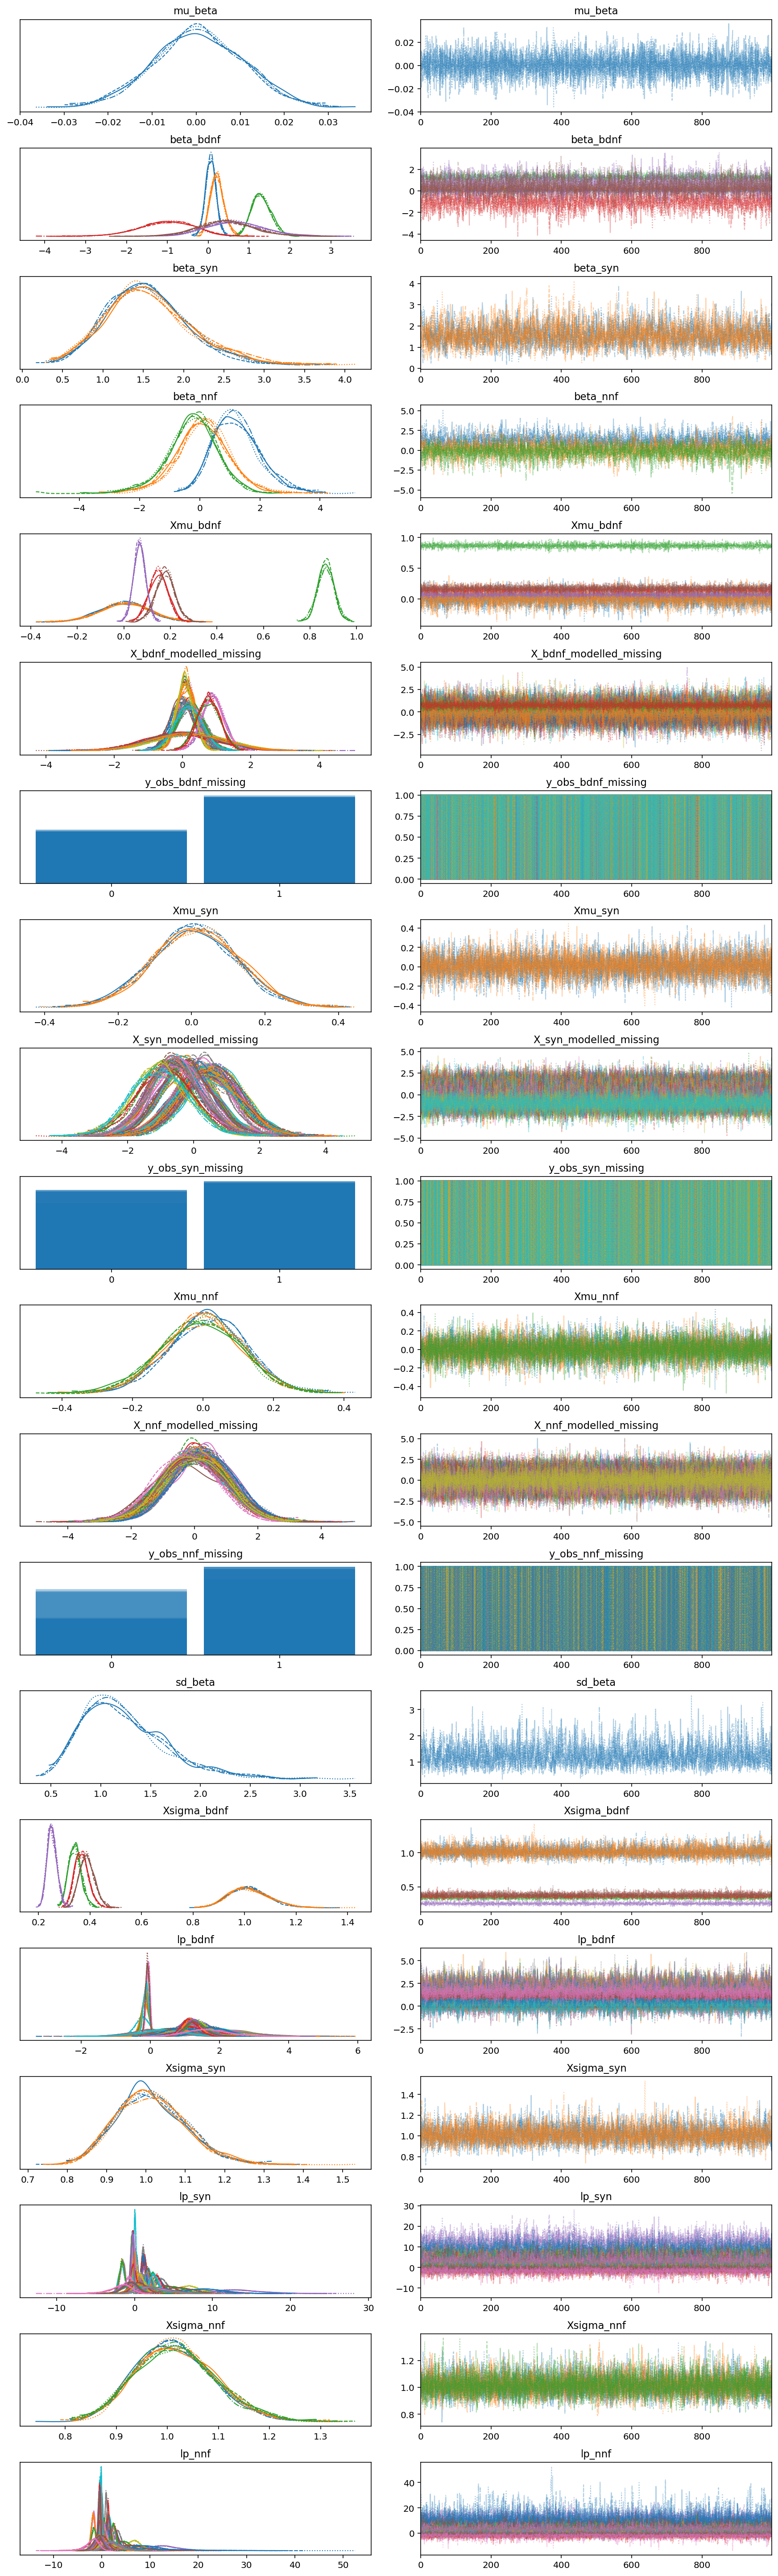

In [7]:
# --- Plot traces of all variables --- #
pm.traceplot(trace_hierar);

In [8]:
# --- Statistical summary --- #
stats = pm.summary(trace_hierar, round_to=None);
stats

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_beta         0.001  0.010  -0.020    0.018      0.000    0.000    9452.0   
beta_bdnf[0,0]  0.063  0.130  -0.193    0.298      0.002    0.002    4595.0   
beta_bdnf[1,0]  0.217  0.163  -0.065    0.551      0.003    0.002    3956.0   
beta_bdnf[2,0]  1.298  0.238   0.852    1.741      0.005    0.004    1917.0   
beta_bdnf[3,0] -1.025  0.686  -2.303    0.223      0.014    0.010    2409.0   
...               ...    ...     ...      ...        ...      ...       ...   
lp_dnt[92,0]    0.121  2.124  -3.626    4.469      0.037    0.030    3328.0   
lp_dnt[93,0]   -2.598  2.734  -7.463    2.466      0.049    0.038    3164.0   
lp_dnt[94,0]    0.110  2.064  -3.608    4.248      0.038    0.033    2971.0   
lp_dnt[95,0]   -0.046  1.991  -4.046    3.588      0.035    0.029    3274.0   
lp_dnt[96,0]   -2.125  2.727  -7.253    2.580      0.053    0.037    2689.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
mu_beta         1109.0    9441.0    2593.0    1.0  
beta_bdnf[0,0]  2843.0    4566.0    3331.0    1.0  
beta_bdnf[1,0]  3279.0    4035.0    3154.0    1.0  
beta_bdnf[2,0]  1917.0    1906.0    2700.0    1.0  
beta_bdnf[3,0]  2303.0    2459.0    2840.0    1.0  
...                ...       ...       ...    ...  
lp_dnt[92,0]    2474.0    3293.0    2943.0    1.0  
lp_dnt[93,0]    2620.0    3272.0    3103.0    1.0  
lp_dnt[94,0]    1934.0    2942.0    2771.0    1.0  
lp_dnt[95,0]    2289.0    3278.0    2920.0    1.0  
lp_dnt[96,0]    2689.0    2772.0    2965.0    1.0  

[657 rows x 11 columns]

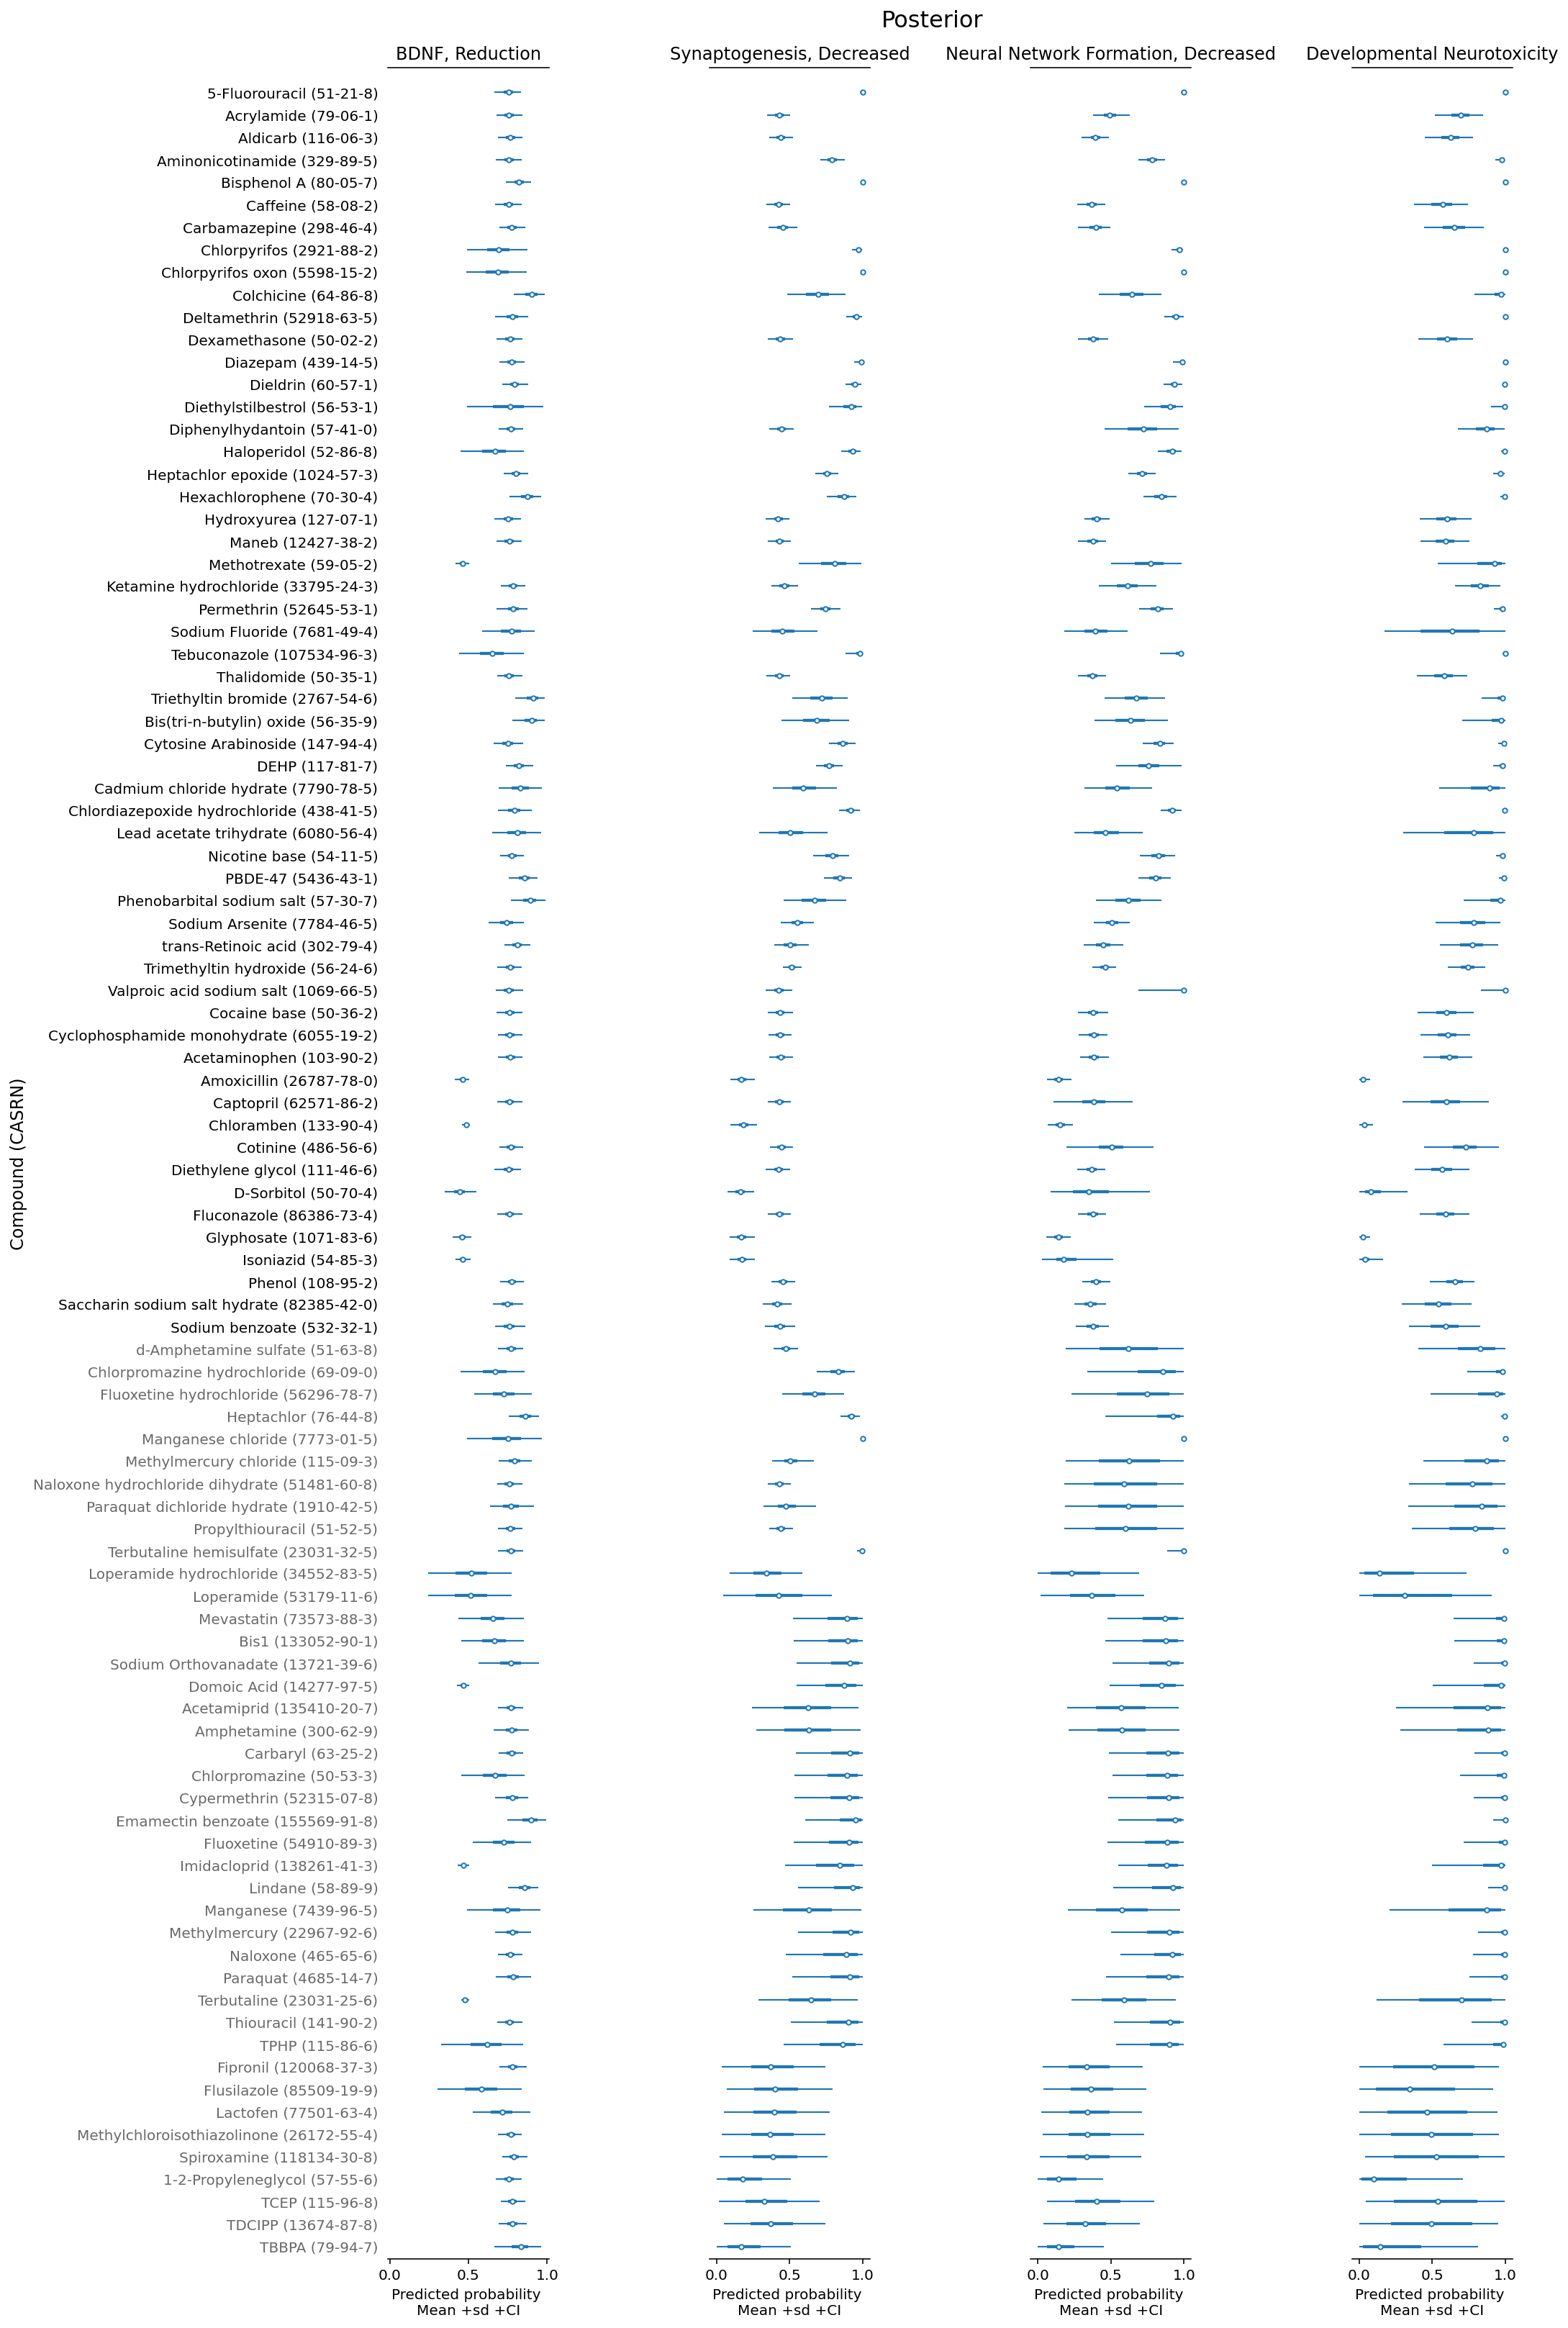

In [9]:
# --- Plot the results --- #

ylabels= data["Chemical"].astype(str) + " (" + data["CASRN"].astype(str) + ")"

fig, ax = plt.subplots(1, 4, figsize=(14,28), sharey=True)


ax0 = pm.forestplot(idata_hierar.posterior, 
                   var_names='lp_bdnf', combined=True, transform=logistic,
                   textsize=10, ax = ax[0])
ax1 = pm.forestplot(idata_hierar.posterior, 
                   var_names='lp_syn', combined=True, transform=logistic,
                   textsize=10, ax = ax[1])

ax2 = pm.forestplot(idata_hierar.posterior, 
                   var_names='lp_nnf', combined=True, transform=logistic,
                   textsize=10, ax = ax[2])
ax3 = pm.forestplot(idata_hierar.posterior, 
                   var_names='lp_dnt', combined=True, transform=logistic,
                   textsize=10, ax = ax[3])

ax[0].set_yticklabels(ylabels[::-1]) #weight = 'bold'

for ind in range(0,41):
    ax[0].get_yticklabels()[ind].set_color("dimgray") #Compounds non-tested in both in vitro studies

ax[0].set_xlim([-0.01,1.01])

for ax_ in ax:
    ax_.set_xlabel("Predicted probability \nMean +sd +CI")

ax[0].set_ylabel("Compound (CASRN)", fontsize=12)
ax[0].set_title("BDNF, Reduction", fontsize=12)
ax[1].set_title("Synaptogenesis, Decreased", fontsize=12)
ax[2].set_title("Neural Network Formation, Decreased", fontsize=12)
ax[3].set_title("Developmental Neurotoxicity", fontsize=12);

plt.subplots_adjust(wspace=1)
plt.suptitle("Posterior", y=0.9, fontsize=16); 
#fig.savefig("./Posterior.pdf", bbox_inches='tight')
#plt.tight_layout();

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy   1.19.1
arviz   0.10.0
pandas  1.1.1
theano  1.0.4
pymc3   3.9.3
seaborn 0.11.0
last updated: Tue Oct 13 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
